In [40]:
import importlib
import numpy as np
from tqdm.auto import tqdm
import pickle

import hydra
import logging

from prol.process import (
    get_cycle,
    get_torch_dataset,
    get_task_indicies_and_map,
    get_sequence_indices
)
from prol.utils import get_dataloader

In [41]:
class SetParams:
    def __init__(self, dict) -> None:
        for k, v in dict.items():
            setattr(self, k, v)

def get_modules(name):
    try: 
        module1 = importlib.import_module(f"prol.models.{name}")
        module2 = importlib.import_module(f"prol.datahandlers.{name}_handle")
    except ImportError:
        print(f"Module {name} not found")
    return module1, module2

In [192]:
# input parameters
params = {
    "dataset": "mnist",
    "method": "timecnn",       # select from {proformer, cnn, mlp}
    "N": 20,                     # time between two task switches                   
    "t": 500,                  # training time
    "T": 5000,                   # future time horizon
    "task": [[2, 3]],    # task specification
    "contextlength": 200,       
    "seed": 1996,              
    "image_size": 64,           
    "device": "cuda:0",             
    "lr": 1e-3,         
    "batchsize": 64,
    "epochs": 1000,
    "verbose": True,
    "reps": 100,                 # number of test reps
    "outer_reps": 3
}
args = SetParams(params)

In [198]:
def get_task_indicies_and_map(tasks: list, y: np.ndarray, type='covariate-shift'):
    """Get the indices for each task + the label mapping

    Parameters
    ----------
    tasks : list
        task specification e.g. [[0, 1], [2, 3]]
    y : np.ndarray
        dataset targets
    """
    tasklib = {}
    for i, task in enumerate(tasks):
        tasklib[i] = []
        for lab in task:
            tasklib[i].extend(
                np.where(y == lab)[0].tolist()
            )
    if type == 'covariate-shift':
        mapdict = {}
        for task in tasks:
            for i, lab in enumerate(task):
                mapdict[lab] = i
        maplab = lambda lab : mapdict[lab]
        return tasklib, maplab
    elif type == 'label-swap':
        assert len(tasklib) == 1
        assert len(tasks) == 1
        assert len(tasks[0]) == 2
        
        taskids = np.array(tasklib[0])
        np.random.seed(1)
        taskids = taskids[np.random.permutation(len(taskids))]
        tasklib_ = {}
        tasklib_[0] = taskids[:len(taskids)//2].tolist()
        tasklib_[1] = taskids[len(taskids)//2:].tolist()
        
        tasks_ = [tasks[0], [10, 11]]
        mapdict = {}
        for task in tasks_:
            for i, lab in enumerate(task):
                mapdict[lab] = i
        mapdict[10] = 1
        mapdict[11] = 0
        maplab = lambda lab : mapdict[lab] 

        dummydict = {
            tasks[0][0]: 10, 
            tasks[0][1]: 11
        }
        dummylab = lambda lab : dummydict[lab]
        return tasklib_, maplab, dummylab

In [199]:
# get source dataset
root = '/cis/home/adesilva/ashwin/research/ProL/data'
torch_dataset = get_torch_dataset(root, name=args.dataset)

In [200]:
tasklib, maplab, dummylab = get_task_indicies_and_map(args.task, torch_dataset.targets.numpy(), type='label-swap')

In [201]:
torch_dataset.targets[tasklib[1]] = torch_dataset.targets[tasklib[1]].apply_(dummylab)

In [202]:
train_SeqInd, updated_taskInd = get_sequence_indices(
            N=args.N, 
            total_time_steps=args.t, 
            tasklib=tasklib, 
            seed=1996,
            remove_train_samples=True
        )

In [203]:
torch_dataset.targets[train_SeqInd[:50]]

tensor([ 3,  3,  3,  3,  2,  2,  3,  2,  2,  3,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  3, 10, 11, 11, 11, 11, 10, 11, 11, 10, 11, 10, 11, 11, 11, 10, 10,
        11, 10, 11, 11,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2])

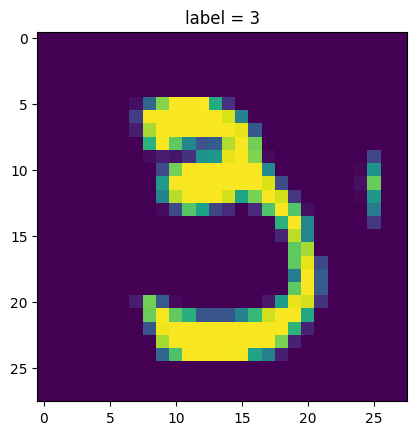

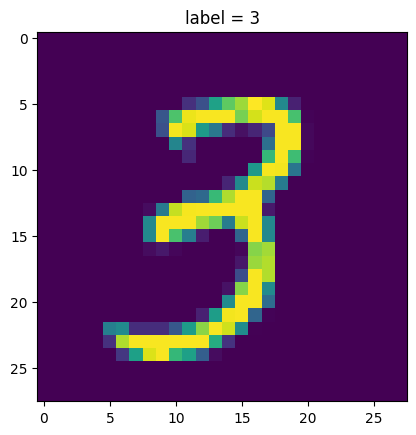

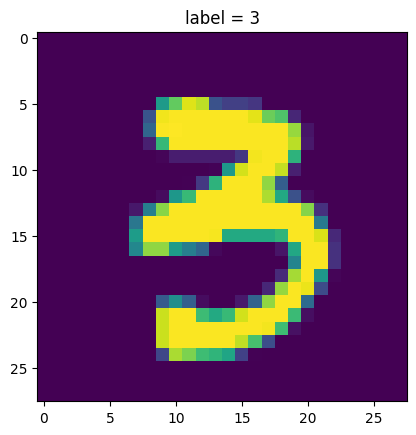

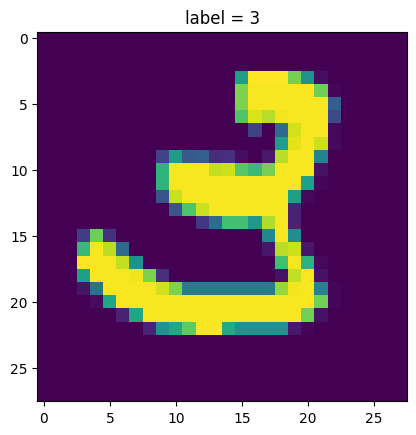

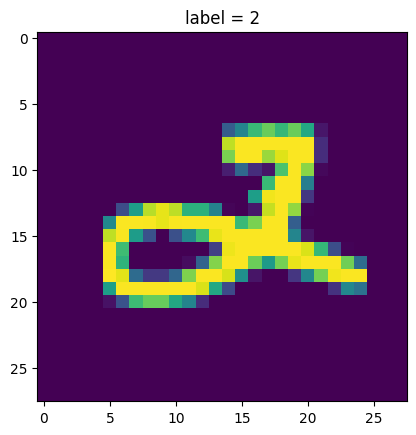

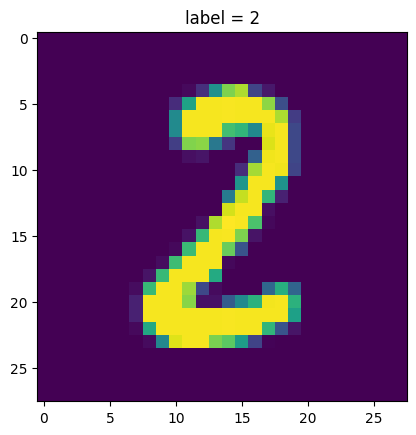

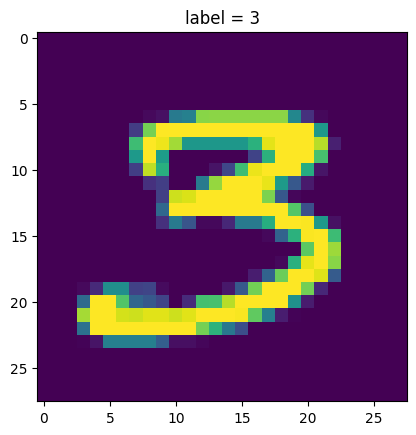

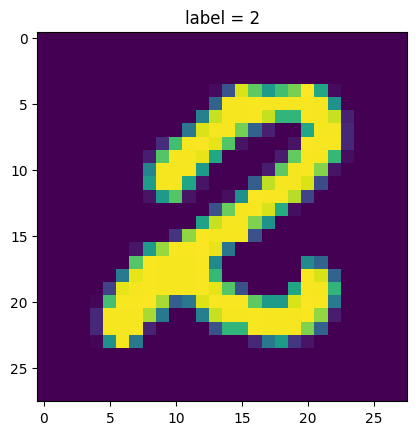

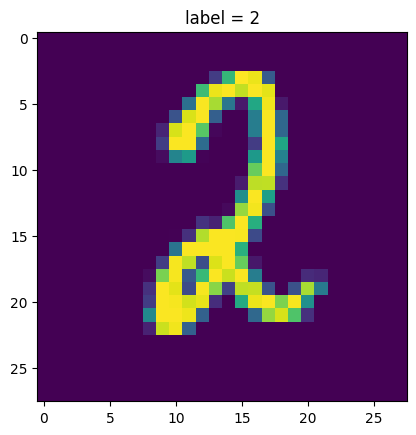

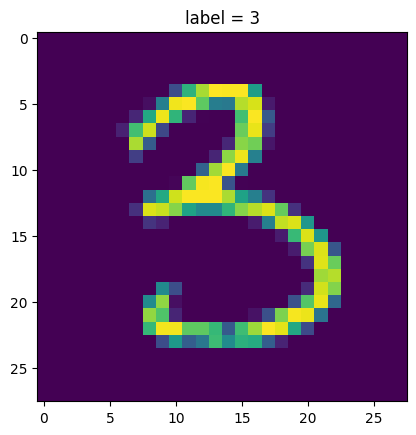

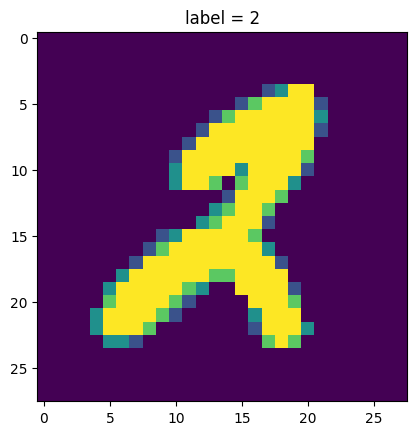

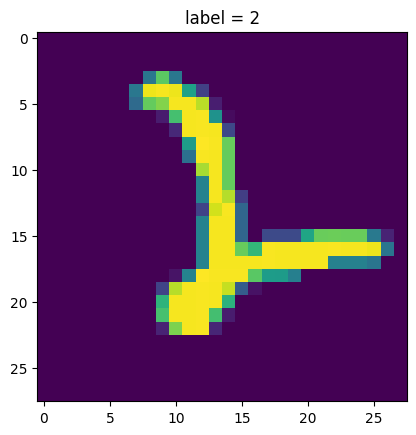

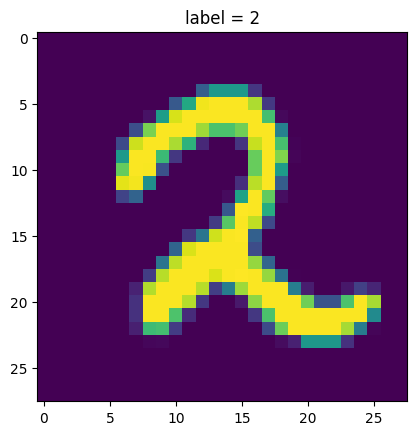

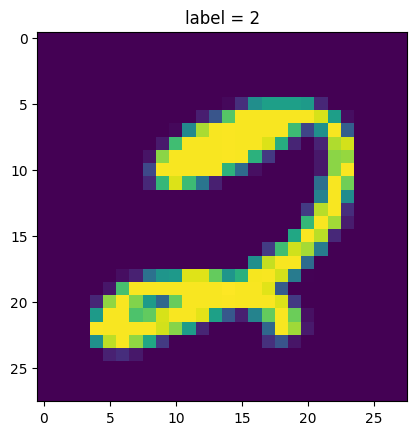

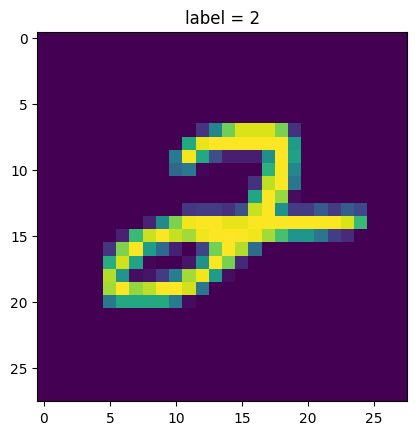

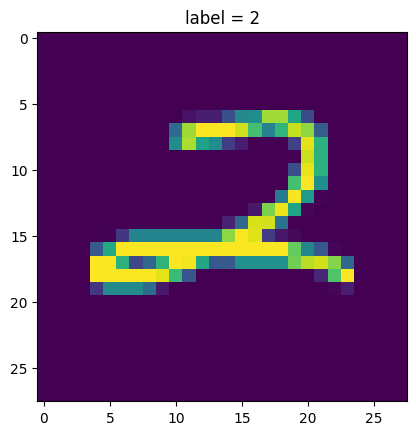

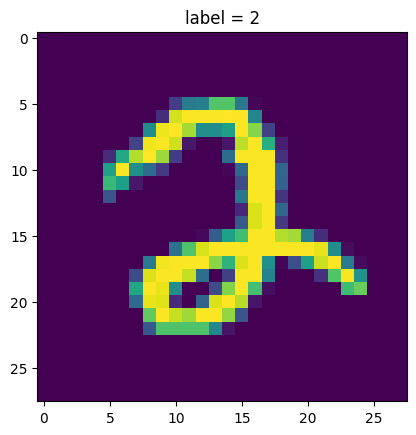

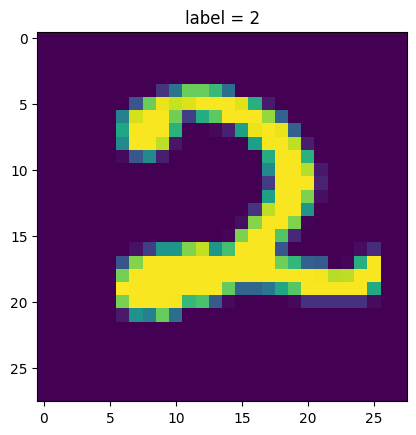

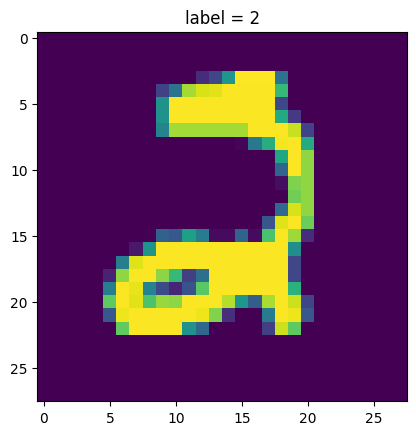

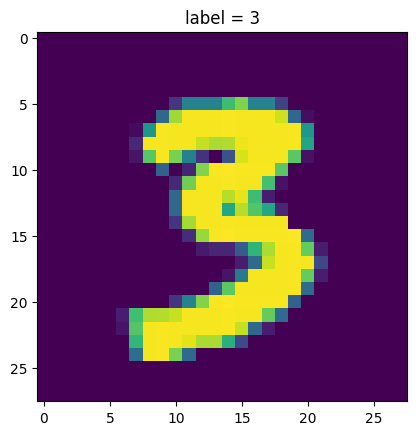

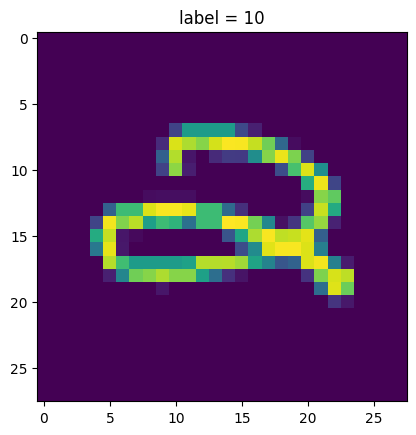

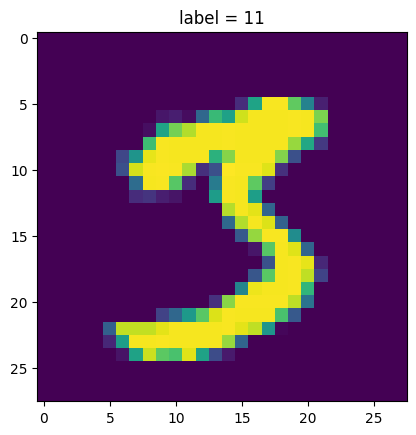

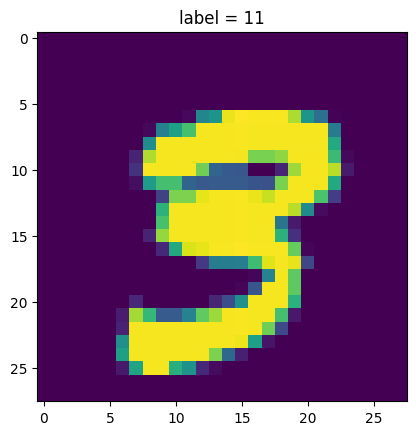

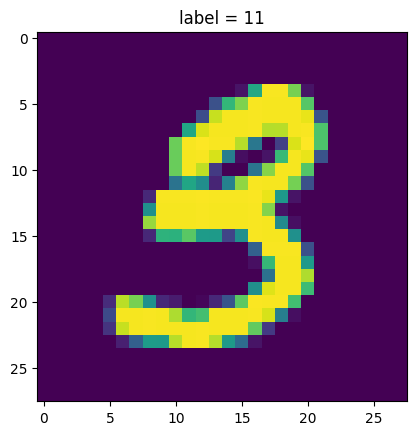

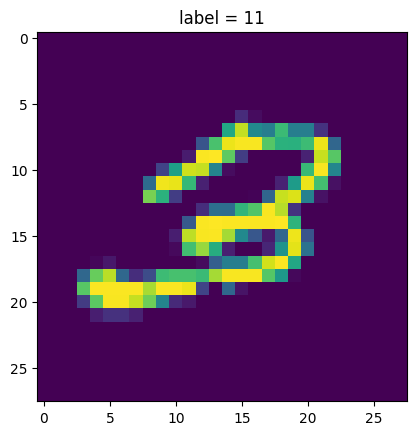

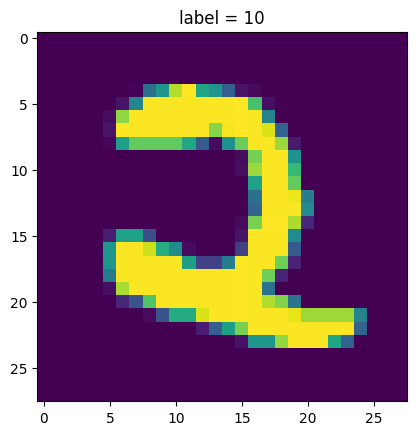

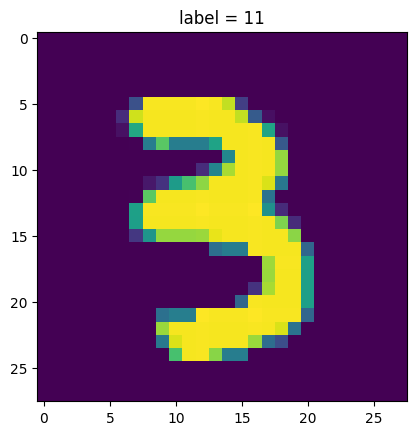

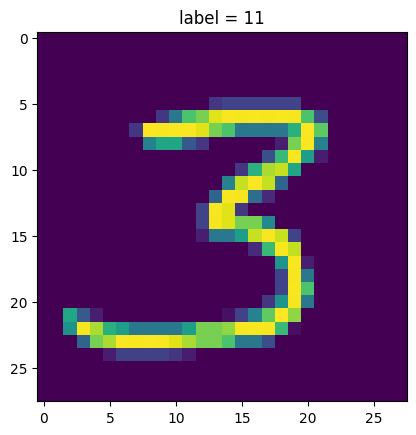

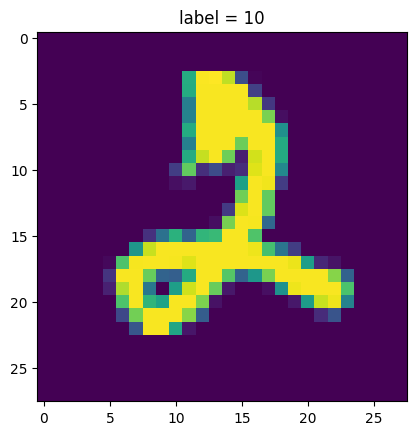

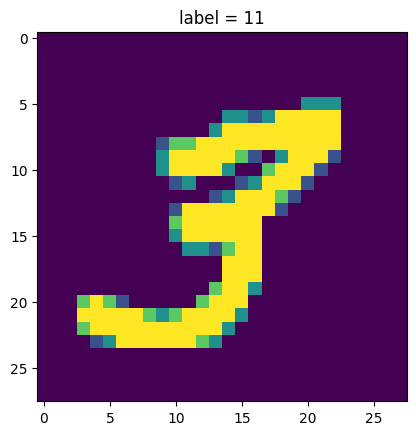

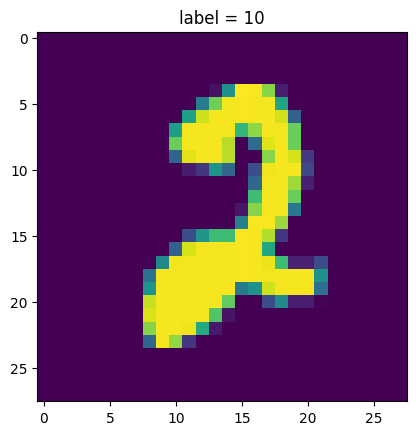

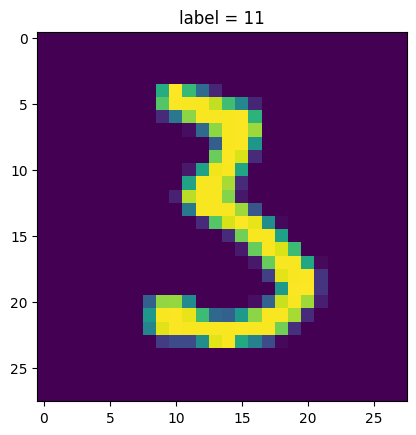

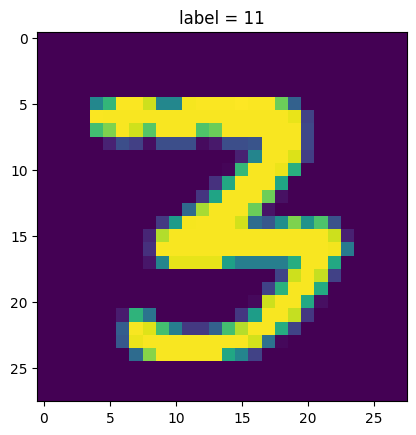

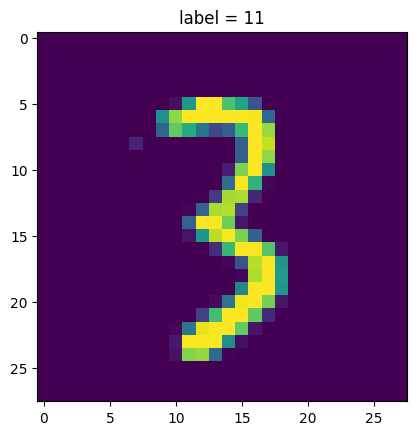

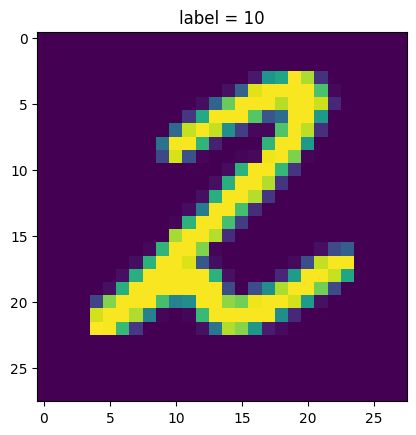

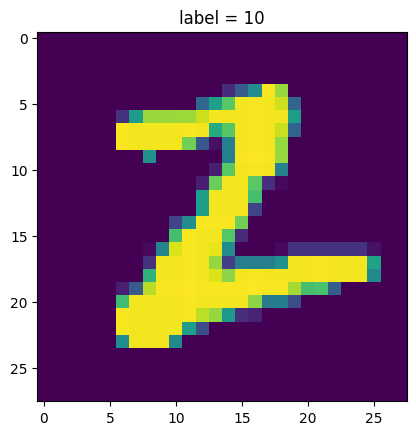

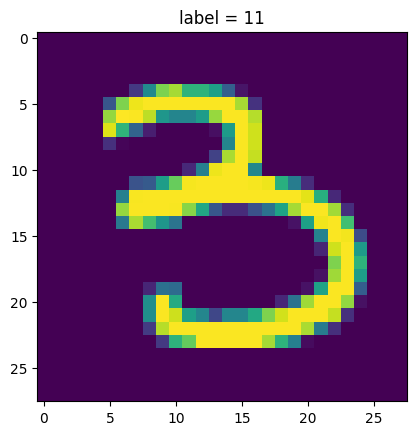

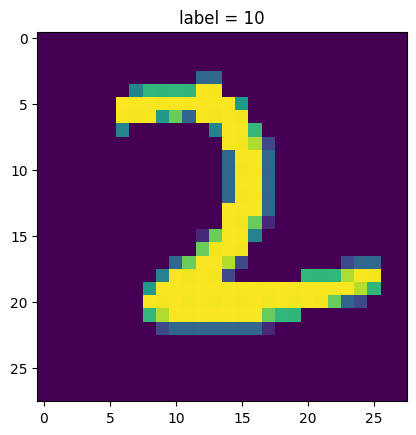

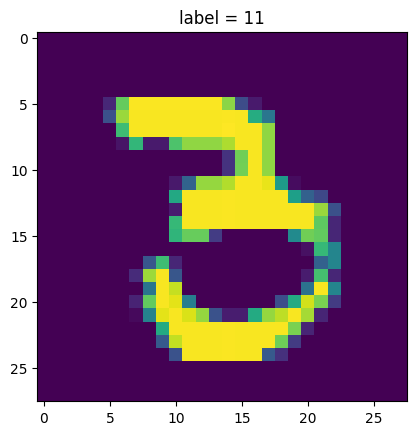

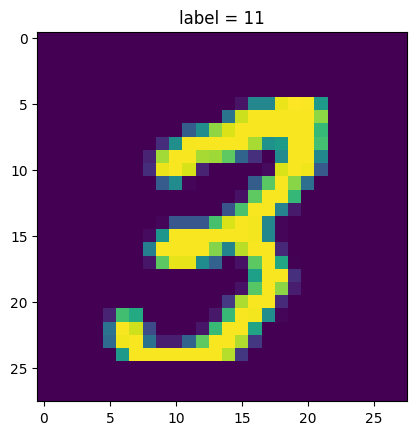

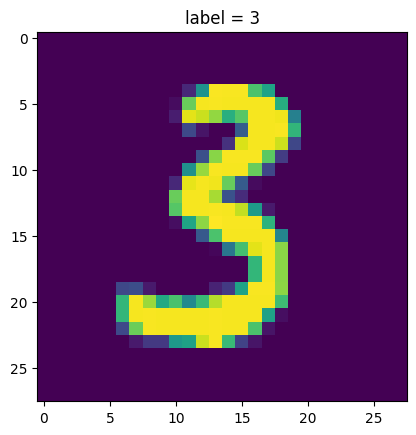

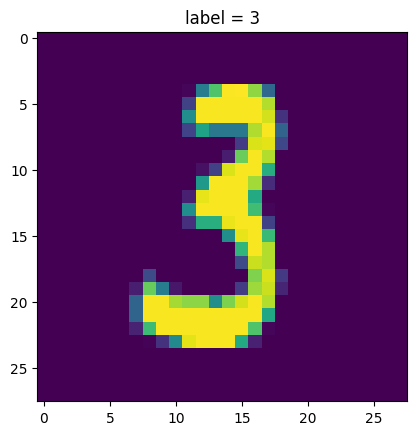

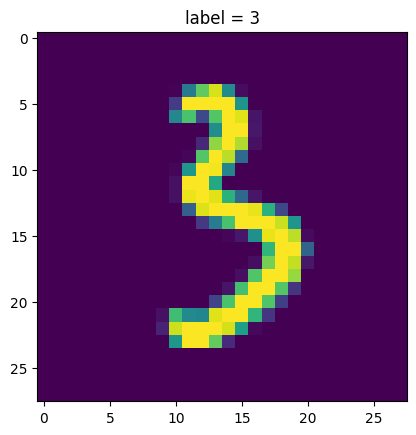

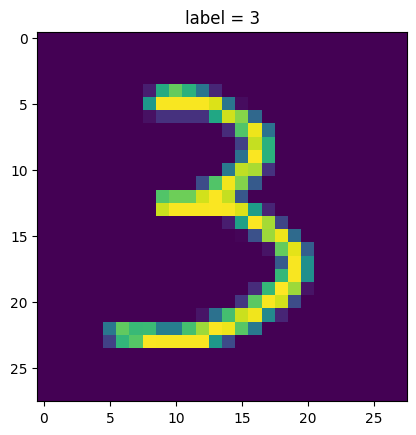

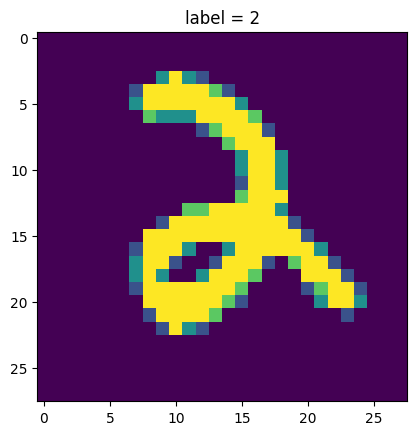

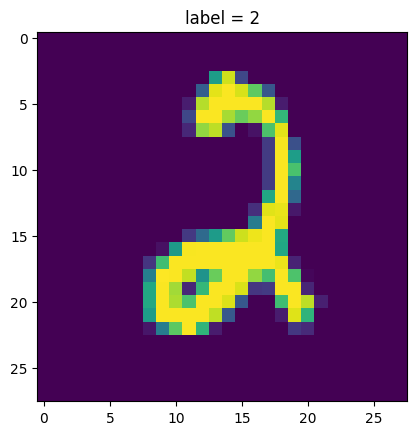

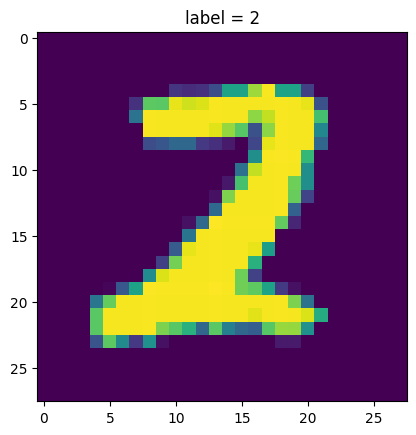

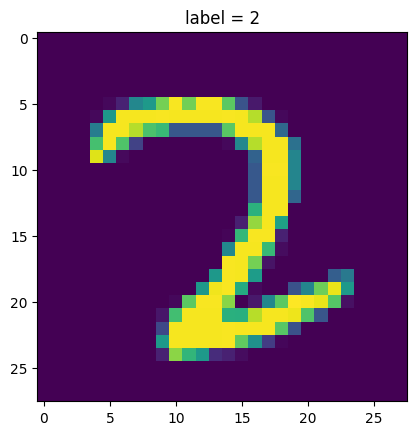

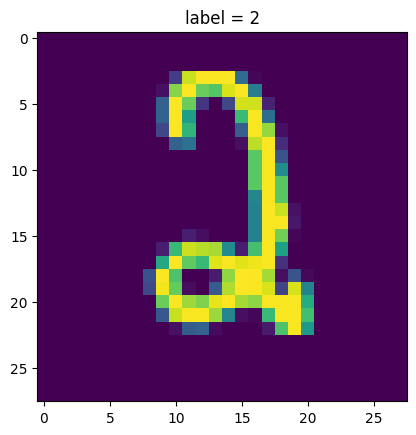

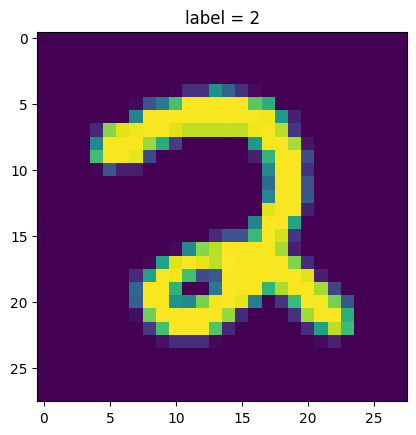

In [204]:
import matplotlib.pyplot as plt
for im, lab in zip(torch_dataset.data[train_SeqInd[:50]], torch_dataset.targets[train_SeqInd[:50]]):
    plt.imshow(im)
    plt.title(f'label = {lab}')
    plt.show()
